# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="https://github.com/ParisaMousavi/CarND-LaneLines-P1/blob/master/examples/line-segments-example.jpg?raw=1" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="https://github.com/ParisaMousavi/CarND-LaneLines-P1/blob/master/examples/laneLines_thirdPass.jpg?raw=1" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


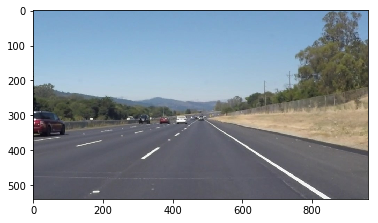

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

```python
cols = 2
rows = (len(results)+1)//cols
    
plt.figure(figsize=(10, 11))
for i, image in enumerate(results):
    plt.subplot(rows, cols, i+1)
    cmap = 'gray' if len(image.shape)==2 else cmap # gray scale if it is one channel
    plt.imshow(image, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()
```

### Detect white and yellow lane lines with RGB

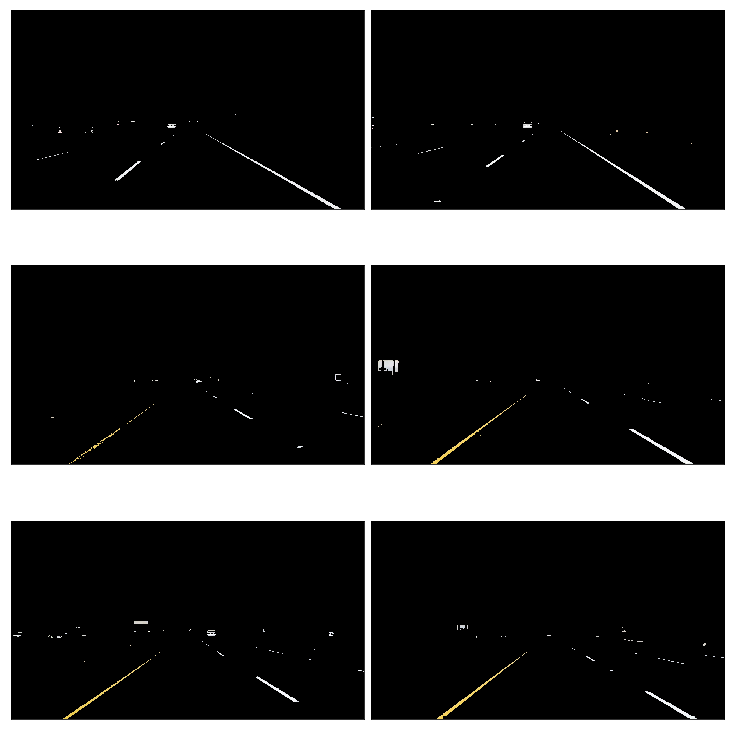

In [3]:
def detect_white_yellow_lanes(image): 
    """
    - detect white lines
    - detect yellow lines
    - merge both images with eachother
    - apply the merged image as mask to the main image
    - return the result image
    """
    # detect the white lane lines in the image
    lower_range = np.uint8([200, 200, 200])
    upper_range = np.uint8([255, 255, 255])
    white_lanes = cv2.inRange(image, lower_range, upper_range)
    
    # detect the yellow lane lines in the image
    lower_range = np.uint8([200, 200,   0])
    upper_range = np.uint8([255, 255, 255])
    yellow_lanes = cv2.inRange(image, lower_range, upper_range)
    
    # merge white and yellow result with eachother
    white_and_yellow_lanes = cv2.bitwise_or(white_lanes, yellow_lanes)
    
    # apply the merged image as mask to the image 
    masked = cv2.bitwise_and(image, image, mask = white_and_yellow_lanes)
    
    return masked

"""
Define mock/test object
"""
results = []
for filename in os.listdir("test_images/") :
    img = mpimg.imread('test_images/' + filename )
    result=detect_white_yellow_lanes(img)
    results.append(result)

cols = 2
rows = (len(results)+1)//cols
    
plt.figure(figsize=(10, 11))
for i, image in enumerate(results):
    plt.subplot(rows, cols, i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

### Convert to gray scale

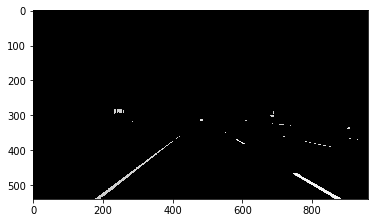

In [4]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

"""
Define mock/test object
"""
test_gray = grayscale(image)
plt.imshow(test_gray , cmap = 'gray')


### Generate the Gaussian blur of the image

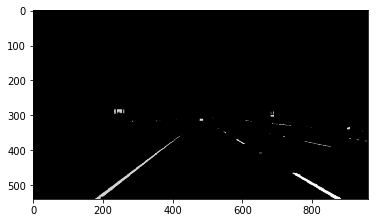

In [5]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

"""
Define mock/test object
"""
kernel_size = 3
test_blur = gaussian_blur(test_gray , kernel_size)
plt.imshow(test_blur , cmap = 'gray')

### Detect Canny edges

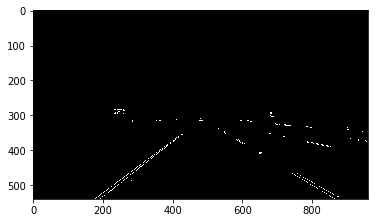

In [6]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

"""
Define mock/test object
"""
test_canny = canny(test_blur , 50,160)
plt.imshow(test_canny , cmap = 'gray')

### Define the region of the interest

In [7]:
def region_of_interest(img, vertices):
    """
    Applies a mask to the image and mask is defined by vertices.
    """
    # create an empty matics for drawing the mask on it
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # draw the mask based on the vertices and fill in the polygon    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # only the part of the image which is covered with mask is returned
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

### Detect the lines with Hough transform

In [8]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)    
    
    return lines

### Extract line properties

In [9]:
def line_properties_extractor(line):
    """
    Extract the properties of each line:
    - Slope
    - Intercept
    - Length    
    - Remove vetival and horizental lines
    """
    slope = None
    intercept = None
    length = None
    if line is not None:
        for x1, y1, x2, y2 in line:
            if x2==x1 or y2==y1 :
                continue # Remove vetival and horizental lines
            slope = (y2-y1)/(x2-x1)
            if slope == 0 :
                continue # remove horizontal line
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
    return slope, intercept, length

"""
Define mock/test object
"""
arr = np.array( [[[ 669, 417, 787, 417]],
                 [[ 490, 313, 658, 406]]] )
result = line_properties_extractor (arr[0])
print(result)

(None, None, None)


### Inspect lines

In [10]:
def inspect_lines(lines):
    """
    Inspect each line:
    - Remove vertical lines
    - Remove horizontal lines
    - Categorize right and left line for further usages
    - Calculate the mean of right and left lines to convert all to one line
    """
    left_lines_group = []
    right_lines_group = []
    left_lines_length = []
    right_lines_length = []
    
    if lines is not None:
        for line in lines:
            
            # Extract the properties of each line
            slope, intercept, length = line_properties_extractor (line)
            
            if slope is not None and intercept is not None and length is not None :
                if slope < 0: 

                    # Categorize right and left line for further usages
                    left_lines_group.append((slope, intercept)) 

                    # Calculate the mean of right and left lines to convert all to one line
                    left_lines_length.append((length))
                else:

                    # Categorize right and left line for further usages
                    right_lines_group.append((slope, intercept))

                    # Calculate the mean of right and left lines to convert all to one line
                    right_lines_length.append((length))  
                
        if len(left_lines_length) > 0 :
            best_left_line_candidate = np.dot(left_lines_length , left_lines_group) / np.sum(left_lines_length) 
        else:
            best_left_line_candidate = None

        if len(right_lines_group) > 0 :
            best_right_line_candidate = np.dot(right_lines_length , right_lines_group) / np.sum(right_lines_length) 
        else:
            best_right_line_candidate = None
            
        """
        sample output
        (array([  2.51275919, 189.51067688]), array([  2.51275919, 189.51067688]))
        """
        return best_left_line_candidate, best_right_line_candidate

"""
Define mock/test object
"""
arr = np.array( [[[ 669, 417, 787, 417]],
                 [[ 490, 313, 658, 406]]] )
result = inspect_lines (arr)
print(result)

(None, array([ 0.55357143, 41.75      ]))


### Calculate general lane lines

In [11]:
def calculate_general_lane_lines(maxy, miny, lines):
    """
    Calculate a general right lane and a general left lane 
    based on calculated best candidate for the right and left 
    lines and the image size to have the full length lines.    
    """
    
    # get the best candidated for the left and rigth lane lines slope and intercept
    #l,r = inspect_lines(lines)
    
    try:
        l = lines[0]
  
    except:
        l = None
        
    try:
        r = lines[1]
    except:
        r = None
    
    if l is not None:
        x1 = int((maxy - l[1])/l[0])
        x2 = int((miny - l[1])/l[0])
        general_laft_lane = ((x1, maxy), (x2, miny))
    else:
        general_laft_lane = None
    
    if r is not None:
        x1 = int((maxy - r[1])/r[0])
        x2 = int((miny - r[1])/r[0])
        general_right_lane = ((x1, maxy), (x2, miny))
    else:
        general_right_lane = None
    
    
    """
    sample output
    (((139, 540), (53, 324)), ((139, 540), (53, 324)))
    """
    return general_laft_lane , general_right_lane

"""
Define mock/test object
"""
arr = np.array( [[[ 669, 417, 787, 417]],
                 [[ 490, 313, 658, 406]]] )
result = inspect_lines(arr)
result = calculate_general_lane_lines(image.shape[0] , np.int (image.shape[0] * 0.6),result)
print(result)

(None, ((900, 540), (509, 324)))


### Draw lane lines

In [12]:
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return line_image

### Add weight to the drew lane lines

In [13]:
# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., j=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, j)



## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

We can use this code


```python
for filename in os.listdir( "test_images/") :
    img = mpimg.imread('test_images/' + filename )
    plt.figure()
    plt.imshow(img)
```


In [14]:

class Lanelines:
    def __init__(self,withoutput = False):
        #private attributes
        self.__slope = None
        self.__intercept = None
        self.__length = None
        self.__frame = None
        self.images = []
        self.__left_lanes = []
        self.__right_lanes = []
        
        #private attributes for default values
        self.__kernel_size = 3

        self.__low_threshold = 30
        self.__high_threshold = 150

        self.__rho = 2 # distance resolution in pixels of the Hough grid
        self.__theta = np.pi/180 # angular resolution in radians of the Hough grid
        self.__threshold = 20     # minimum number of votes (intersections in Hough grid cell)
        self.__min_line_len = 100 #minimum number of pixels making up a line
        self.__max_line_gap = 60    # maximum gap in pixels between connectable line segments
        self._withoutput = withoutput
        
    def processor(self,frame):
        """
        - receives the frame
        - detect the white and yellow lines
        - convert the white and yellow image to gray
        - blur the gray scaled image
        - detect the edges
        - find the lines with hough transforms
        - exrtact the properties of lines
        - analysis and inspect the lines
        - generalized lane lines based on the previous lines
        - draw the lane lines on the Zero_like matrics
        - Merge the image with the line image and add weight to the lines
        """
        
        # 0 : keep the original frame in a privte field
        self.__frame = frame
        if self._withoutput == True : 
            self.images.append(frame)
        
        # 1- find the yellow and white lane lines
        white_yellow_lanes = detect_white_yellow_lanes(frame)
        if self._withoutput == True: 
            self.images.append(white_yellow_lanes)

        # 2- make a gray scale image
        gray = grayscale(white_yellow_lanes)
        if self._withoutput == True: 
            self.images.append(gray)

        # 3- apply gaussian blure to gray scale
        gaussian_gray = gaussian_blur(gray, self.__kernel_size)
        if self._withoutput == True: 
            self.images.append(gaussian_gray)

        # 4- find the edges
        edges = canny(gaussian_gray, self.__low_threshold, self.__high_threshold)
        if self._withoutput == True: 
            self.images.append(edges)

        # 5- limit region
        imshape = self.__frame.shape
        my_vertices = my_vertices = np.array([[(140,imshape[0]),(460, 310), (490, 310), (890,imshape[0])]], dtype=np.int32)
        
        # first, define the polygon by vertices
        rows, cols = self.__frame.shape[:2]
        bottom_left  = [cols*0.1, rows*0.95]
        top_left     = [cols*0.4, rows*0.6]
        bottom_right = [cols*0.9, rows*0.95]
        top_right    = [cols*0.6, rows*0.6]        
        vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
        
        # 6- define the region of interest
        masked_edges = region_of_interest(edges, vertices)
        if self._withoutput == True: 
            self.images.append(masked_edges)

        # 7- hough transform to find lines from canny edges
        lines = hough_lines(masked_edges, self.__rho, self.__theta, self.__threshold, self.__min_line_len, self.__max_line_gap)
        
        # 8- inspect the line properties to remove the horizental and vertival lines and clculate the best candinate
        # for the left and right lane line
        result = inspect_lines(lines) 
        # Sample output : (array([  2.51275919, 189.51067688]), array([  2.51275919, 189.51067688]))
        if self._withoutput == True:
            print(result)
        
        
        # 9- calculate the left and right lane lines based on the best candidate of (slope, intercept) for the left and right 
        # lane line and calculate the two endpointsss of the line based on the highest and lowst y and the x1 and x2 are calculated.
        generalized_line = calculate_general_lane_lines(self.__frame.shape[0] , np.int (self.__frame.shape[0] * 0.6),result) 
        # Sample output : (((139, 540), (53, 324)), ((139, 540), (53, 324)))
        if self._withoutput == True:
            print(generalized_line)
        
        # 10- gather generalized lines for optimization      
        result = []
        
        if generalized_line[0] is not None:
            self.__left_lanes.append(generalized_line[0])

        if generalized_line[1] is not None:
            self.__right_lanes.append(generalized_line[1])
            
        
        if len(self.__left_lanes)>0:
            line = np.mean(self.__left_lanes, axis=0, dtype=np.int32)
            line = tuple(map(tuple, line))       
            result.append(line)
        
        if len(self.__right_lanes)>0:
            line = np.mean(self.__right_lanes, axis=0, dtype=np.int32)
            line = tuple(map(tuple, line))         
            result.append(line)

       
        # 11- draw lines on the zero like matrics
        only_lines_img = draw_lane_lines(self.__frame, result)
        if self._withoutput == True: 
            self.images.append(only_lines_img)
        
        # 12- add weight to the lines 
        processed_frame = weighted_img(only_lines_img, self.__frame)
        if self._withoutput == True: 
            self.images.append(processed_frame)
        
        return processed_frame
        


(array([ -0.72302839, 660.06808708]), array([ 0.60199218, 21.71719025]))
(((166, 540), (464, 324)), ((860, 540), (502, 324)))


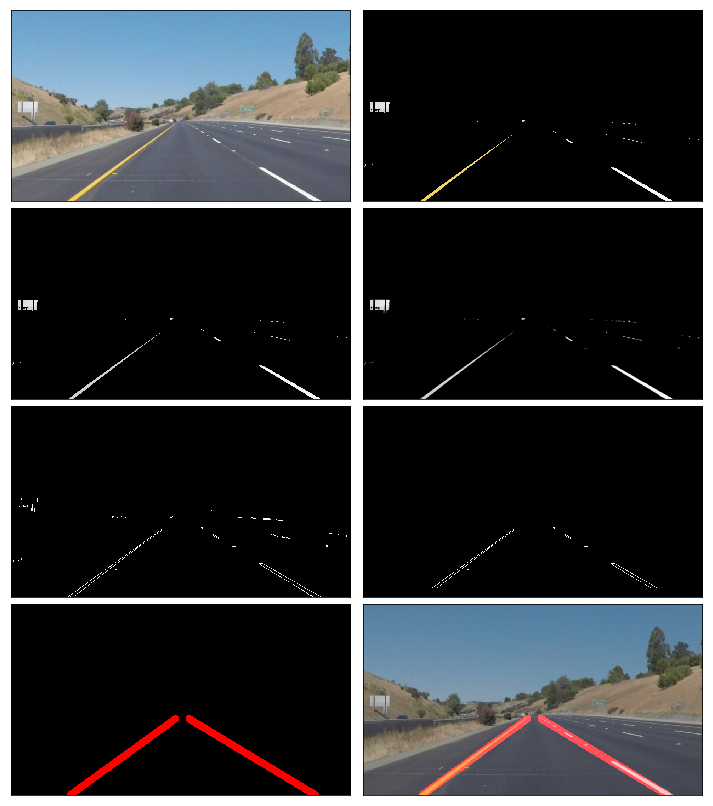

In [15]:
"""
Define mock/test object
"""
lane_line = Lanelines(withoutput = True)

img = mpimg.imread('test_images/' + 'solidYellowCurve2.jpg' )
result = lane_line.processor(img)

if lane_line._withoutput == False :
    plt.imshow(result)
else :
    cols = 2
    rows = (len(lane_line.images)+1)//cols

    plt.figure(figsize=(10, 11))
    for i, image in enumerate(lane_line.images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image , 'gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()




## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

Let's try the one with the solid white lane on the right first ...

In [16]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
lane_line = Lanelines()

clip1 = VideoFileClip( "test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(lane_line.processor) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 72.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 3.43 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
lane_line = Lanelines()

clip2 = VideoFileClip( 'test_videos/solidYellowLeft.mp4')

yellow_clip = clip2.fl_image(lane_line.processor)

%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:09<00:00, 72.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 9.66 s


In [19]:
HTML("""
<video width="960" height="540" controls
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

As this part of the project was a challenge, I needed some sample/test to test and run the code with it, therefore I used this code snippet to save the frames of the video as image to use them as sample and test my code with them and optimize or adjust the code for a better result.  

```python
import cv2
 
# Opens the Video file
cap= cv2.VideoCapture('test_videos/challenge.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('./chalenge_images/kang'+str(i)+'.jpg',frame)
    i+=1
    
cap.release()
cv2.destroyAllWindows()
```


In [20]:
challenge_output =  'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
lane_line = Lanelines()

clip3 = VideoFileClip( 'test_videos/challenge.mp4')

challenge_clip = clip3.fl_image(lane_line.processor)

%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 44.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 6.2 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## References
- https://www.mathopenref.com/coordslope.html
- https://medium.com/activating-robotic-minds/finding-lane-lines-on-the-road-30cf016a1165
- https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/
